In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm

In [2]:
# read data, convert the datetime column ans set it as the index
df = pd.read_csv("EMHIRESPV_TSh_CF_Country_19862015.csv", parse_dates = ["Date"], index_col = ["Date"])

In [3]:
df.columns

Index(['Time_step', 'Year', 'Month', 'Day', 'Hour', 'AL', 'AT', 'BA', 'BE',
       'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'EL', 'HR',
       'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'ME', 'MK', 'NL', 'NO', 'PL', 'PT',
       'RO', 'RS', 'SI', 'SK', 'SE', 'XK', 'UK'],
      dtype='object')

In [4]:
name_map = {
    'AL': "Albania", 'AT': "Austria", 'BA': "Bosnia", 'BE': "Belgium", 'BG': "Bulgaria", 'CH': "Switzerland", "CY": "Cyprus", 
    'CZ': "Czechia", 'DE': "Germany", 'DK': "Denmark", 'EE': "Estonia", 'ES': "Spain", 'FI': "Finland", 'FR': "France", 
    'EL': "Greece", 'HR': "Croatia", 'HU': "Hungary", 'IE': "Ireland", 'IT': "Italy", 'LT': "Lithuania", 'LU': "Luxembourg", 
    'LV': "Latvia", 'ME': "Montenegro", 'MK': "North Macedonia", 'NL': "Netherlands", 'NO': "Norway", 'PL': "Poland", 
    'PT': "Portugal", 'RO': "Romania", 'RS': "Serbia", 'SI': "Slovenia", 'SK': "Slovakia", 'SE': "Sweden", 'XK': "Kosovo", 
    'UK': "United Kingdom"
}

In [5]:
#sns.set_style("whitegrid")

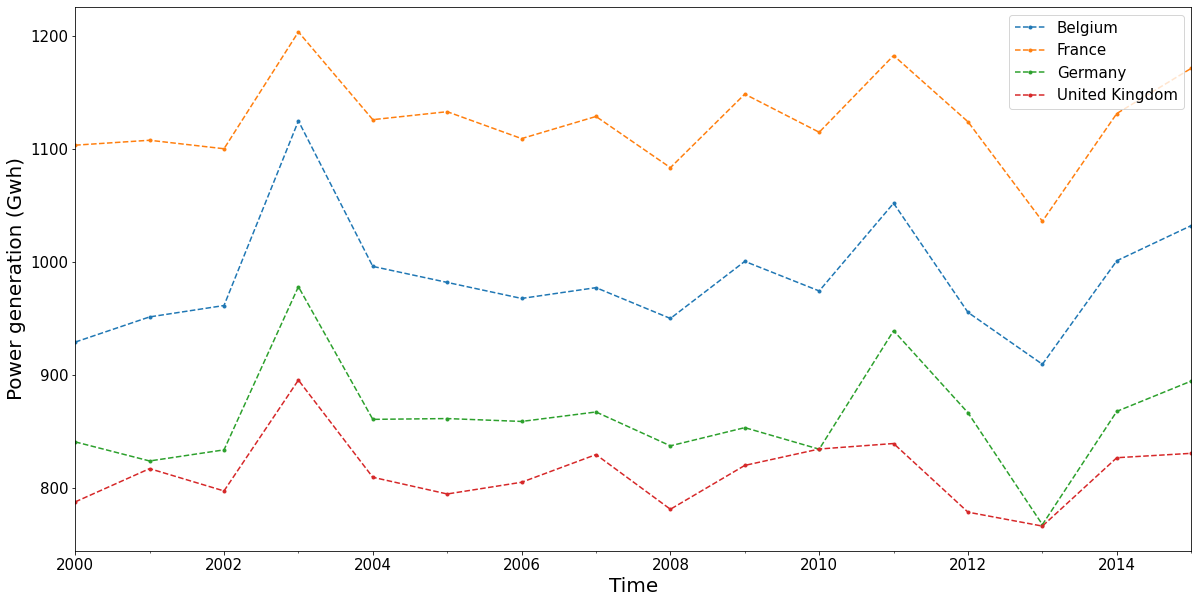

In [6]:
# exploratory plot for the comparision of solar power generation for four countries in Europe
fig, ax = plt.subplots(figsize = (20, 10))
df.loc["2000":"2015"][["BE","FR","DE","UK"]].resample("y").sum().plot(marker = ".", linestyle = "--", ax = ax)
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel("Power generation (Gwh)", fontsize = 20)
ax.tick_params(axis='both', labelsize=15)
ax.legend((name_map["BE"], name_map["FR"], name_map["DE"], name_map["UK"]), fontsize = 15, loc = "upper right")
plt.show()

In [7]:
# Resample daily data
df_daily = df[["BE","FR","DE","UK"]].resample("D").sum()

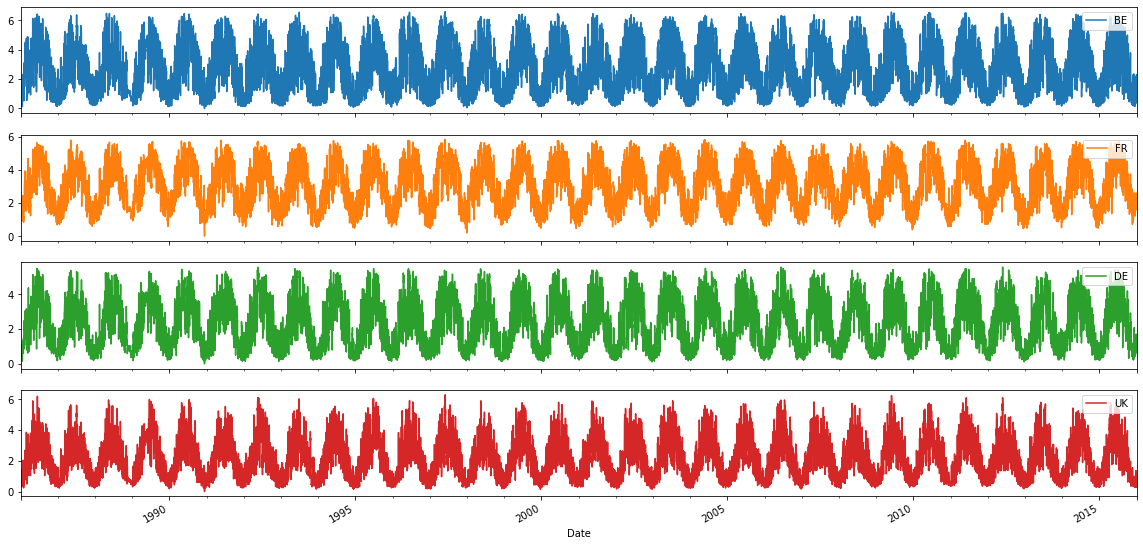

In [8]:
# subplot the daily power generation
df_daily.plot(subplots = True, figsize = (20, 10))
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

In [9]:
# Resample weekly data
df_weekly = df[["BE","FR","DE","UK"]].resample("W").sum()

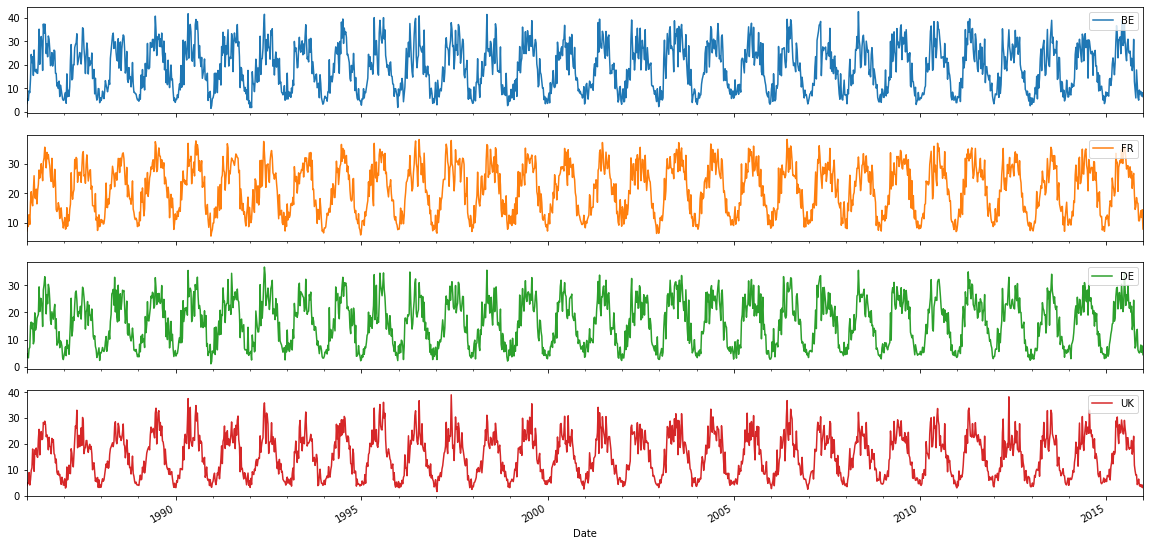

In [10]:
# subplot the weekly power generation
df_weekly.plot(subplots = True, figsize = (20, 10))
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

In [11]:
# Resample monthly data
df_monthly = df[["BE","FR","DE","UK"]].resample("M").sum()

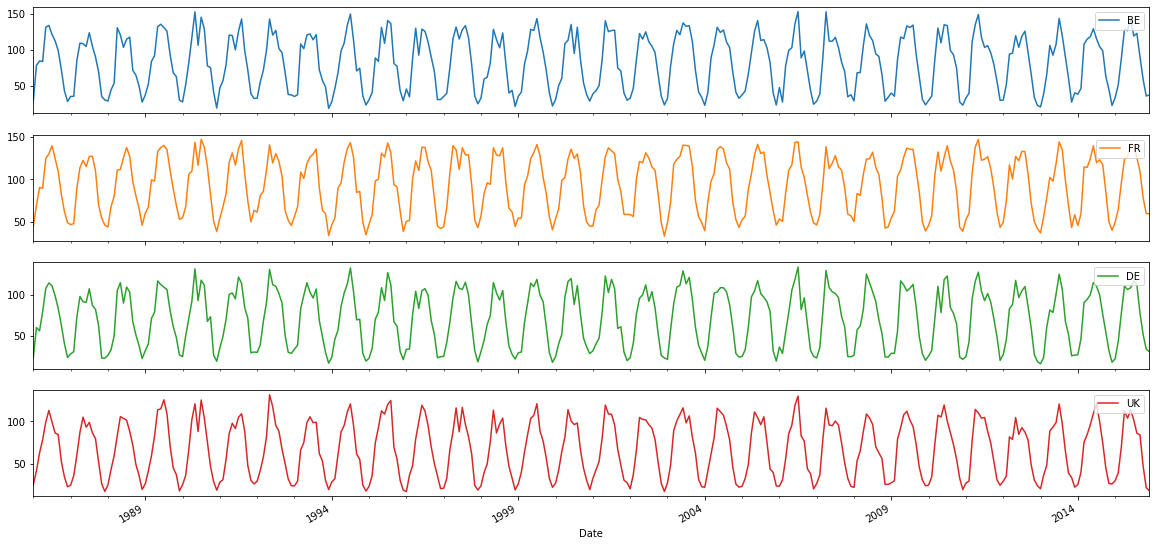

In [12]:
# subplot the monthly power generation
df_monthly.plot(subplots = True, figsize = (20, 10))
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

In [13]:
# Resample yearly data
df_yearly = df[["BE","FR","DE","UK"]].resample("Y").sum()

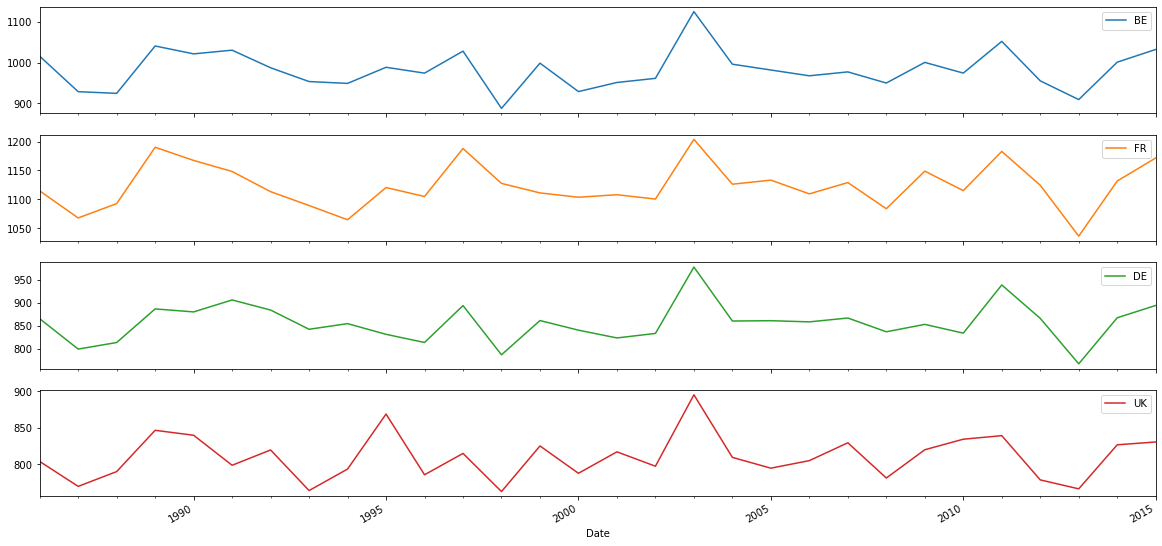

In [14]:
# subplot the yearly power generation
df_yearly.plot(subplots = True, figsize = (20, 10))
[ax.legend(loc=1) for ax in plt.gcf().axes]
plt.show()

In [15]:
# Take monthly data from France as an example, first run the augmented dicky-fuller test function to check the stationality of time series
result = adfuller(df_monthly["FR"])

In [16]:
# based on the p-value, we reject the null hypothesis that the time series is non-stationary. Therefore the time series is stationary. 
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -4.435854956268309
p-value: 0.00025634005258581415


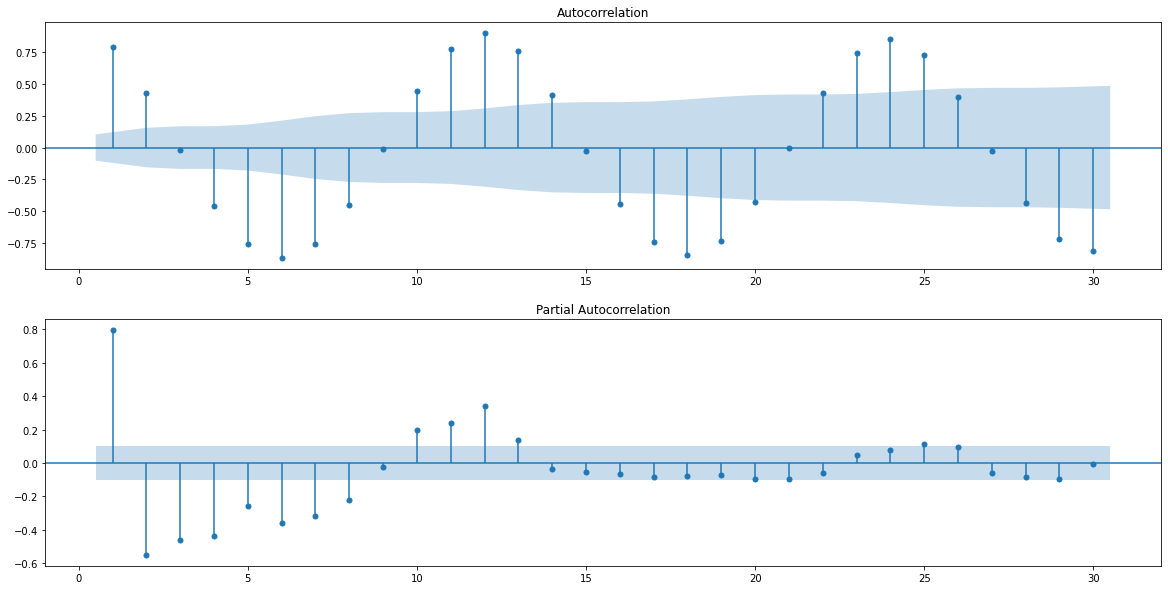

In [17]:
# Will use ARIMA model, so need to create ACF and PACF to determine the best model orders
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
 
# Plot the ACF of df
plot_acf(df_monthly["FR"], lags=30, zero=False, ax=ax1)

# Plot the PACF of df
plot_pacf(df_monthly["FR"], lags=30, zero=False, ax=ax2)

plt.show()

In [18]:
# Use Akaike information criterion (AIC) and Bayesian information criterion (BIC), to test different combinations of model orders
import warnings
warnings.filterwarnings('ignore')

order_aic_bic=[]

# Loop over p values from 0-15
for p in range(15):
  # Loop over q values from 0-15
    for q in range(15):
        try:
            model = SARIMAX(df_monthly["FR"], order=(p,0,q))
            results = model.fit()
            order_aic_bic.append((p,q,results.aic, results.bic))
        except:
            order_aic_bic.append((p,q,np.nan, np.nan))

In [19]:
# Construct DataFrame from order_aic_bic, show the order of increasing AIC and increasing BIC
order_df = pd.DataFrame(order_aic_bic, 
                        columns=["p", "q", "AIC", "BIC"])

print(order_df.sort_values("AIC"))
print(order_df.sort_values("BIC"))

      p   q          AIC          BIC
115   7  10  2692.631492  2762.581365
129   8   9  2702.792422  2772.742295
132   8  12  2702.821827  2784.430012
114   7   9  2708.938007  2775.001775
54    3   9  2710.840421  2761.359773
..   ..  ..          ...          ...
4     0   4  3570.838033  3590.268554
2     0   2  3659.866987  3671.525300
1     0   1  3915.475215  3923.247423
0     0   0  4335.366373  4339.252477
170  11   5          NaN          NaN

[225 rows x 4 columns]
      p   q          AIC          BIC
54    3   9  2710.840421  2761.359773
115   7  10  2692.631492  2762.581365
51    3   6  2733.862482  2772.723522
129   8   9  2702.792422  2772.742295
114   7   9  2708.938007  2775.001775
..   ..  ..          ...          ...
4     0   4  3570.838033  3590.268554
2     0   2  3659.866987  3671.525300
1     0   1  3915.475215  3923.247423
0     0   0  4335.366373  4339.252477
170  11   5          NaN          NaN

[225 rows x 4 columns]


In [20]:
# Based on the results, we can try choosing p = 7, and q = 10, so create the correpsonding model and fit with data
model1 = SARIMAX(df_monthly["FR"], order=(7,0,10))
results1 = model1.fit()
print(results1.summary())

                               SARIMAX Results                                
Dep. Variable:                     FR   No. Observations:                  360
Model:              SARIMAX(7, 0, 10)   Log Likelihood               -1328.316
Date:                Mon, 15 Feb 2021   AIC                           2692.631
Time:                        23:24:56   BIC                           2762.581
Sample:                    01-31-1986   HQIC                          2720.445
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9136      0.017    112.943      0.000       1.880       1.947
ar.L2         -0.6640      0.042    -15.701      0.000      -0.747      -0.581
ar.L3         -1.5759      0.069    -22.977      0.0

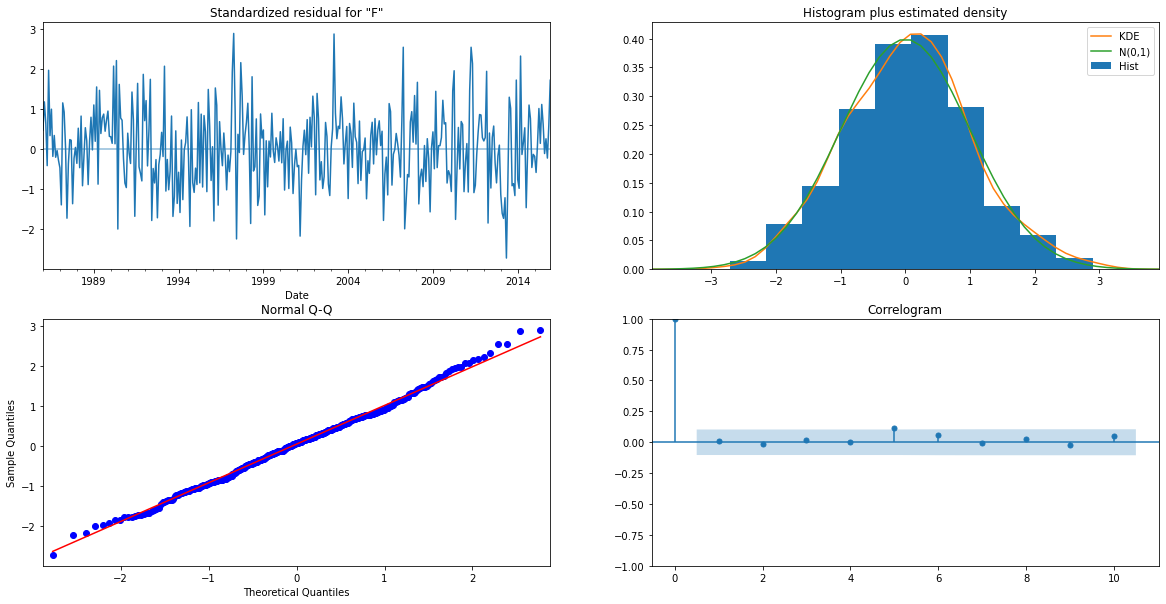

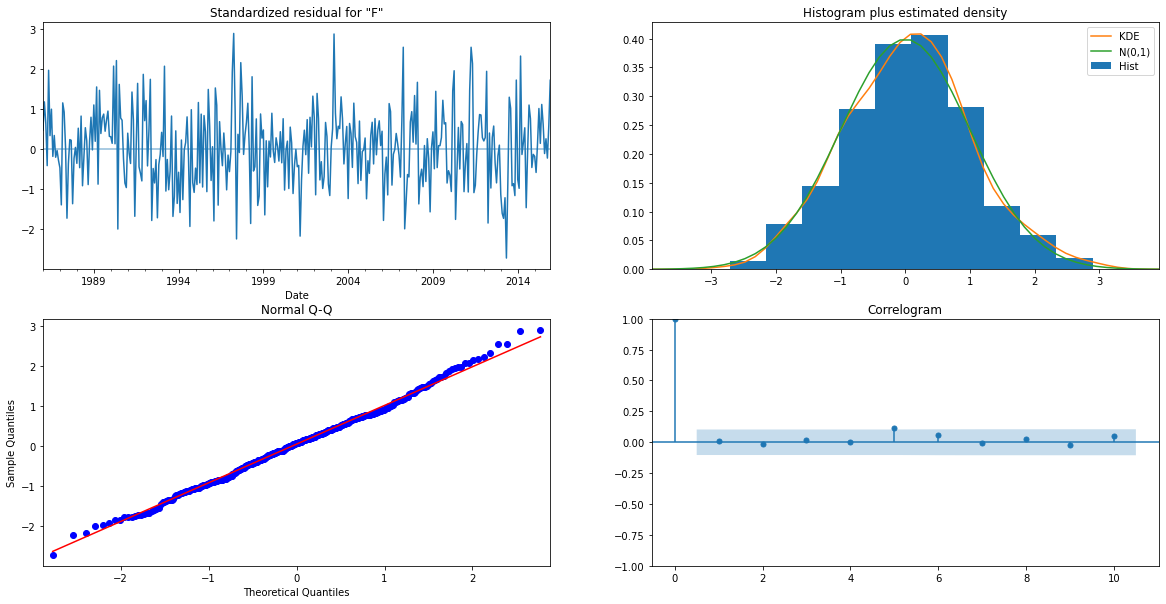

In [21]:
# Create the diagostics plots, and it can been there might exist seasonal patterns based on the standardized residuals.
results1.plot_diagnostics(figsize = (20,10))

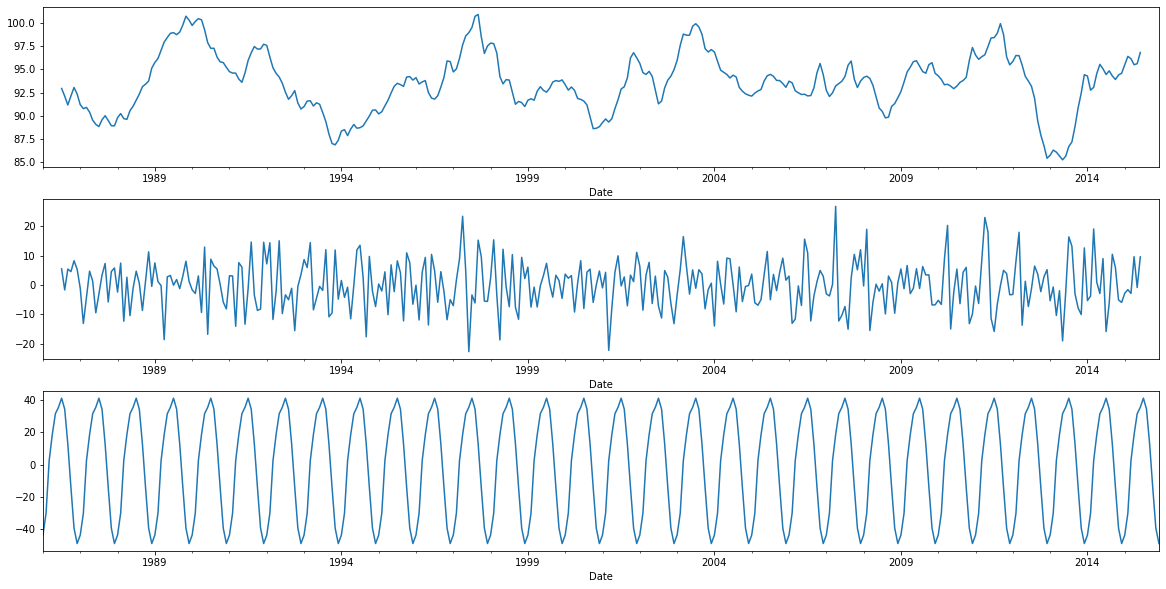

In [22]:
# So next perform and plot additive decomposition of time series for exploring trends, seasonal patterns, and residuals. 
decomp = seasonal_decompose(df_monthly["FR"], freq = 12, model='additive')

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(20,10))
decomp.trend.plot(ax=ax1)
decomp.resid.plot(ax=ax2)
decomp.seasonal.plot(ax=ax3)
plt.show()

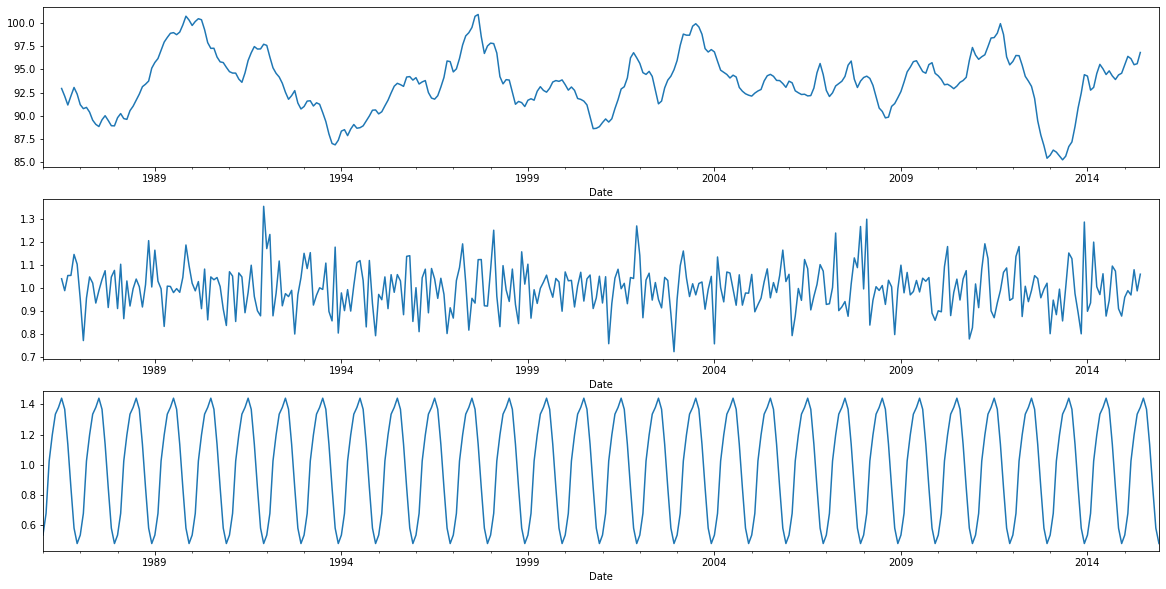

In [23]:
# Also perform and plot multiplicative decomposition of time series for exploring trends, seaonsal patterns, and residuals. 
decomp = seasonal_decompose(df_monthly["FR"], freq = 12, model='multiplicative')

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(20,10))
decomp.trend.plot(ax=ax1)
decomp.resid.plot(ax=ax2)
decomp.seasonal.plot(ax=ax3)
plt.show()

In [24]:
# The pmdarima package is a powerful tool to help choose the model orders with seasonality being considerd.
model2 = pm.auto_arima(df_monthly["FR"], seasonal=True, m=12, d = 1, D=1, max_p=3, max_q=3, trace=True, error_action='ignore', trend = "c", suppress_warnings=True) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=1.64 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2966.196, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2839.527, Time=0.32 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2905.959, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2777.402, Time=0.93 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=2704.836, Time=2.23 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=2706.664, Time=2.38 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=0.99 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=2760.593, Time=1.95 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=2650.991, Time=3.04 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=2728.289, Time=1.51 sec
 ARIMA(2,1,0)(2,1,2)[12]             : AIC=2

In [25]:
# Based on the results, the ARIMA(3,1,0)(2,1,1)[12] is selected as the relatively best one
print(model2.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  360
Model:             SARIMAX(3, 1, 0)x(2, 1, [1], 12)   Log Likelihood               -1309.573
Date:                              Mon, 15 Feb 2021   AIC                           2635.145
Time:                                      23:26:47   BIC                           2665.940
Sample:                                           0   HQIC                          2647.407
                                              - 360                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0035      0.097      0.036      0.971      -0.187       0.195
ar.L1         -0.63

In [26]:
# fit the model with the determined orders
model3 = SARIMAX(df_monthly["FR"], order=(3,1,0), seasonal_order=(2,1,1,12), trend="c")
results3 = model3.fit()

In [27]:
# generating one-step-ahead predictions, extract prediction mean, get confidence intervals, for the latest 36 months
one_step_forecast = results3.get_prediction(start=-36)

mean_forecast = one_step_forecast.predicted_mean

confidence_intervals = one_step_forecast.conf_int()

lower_limits = confidence_intervals.loc[:,'lower FR']
upper_limits = confidence_intervals.loc[:,'upper FR']

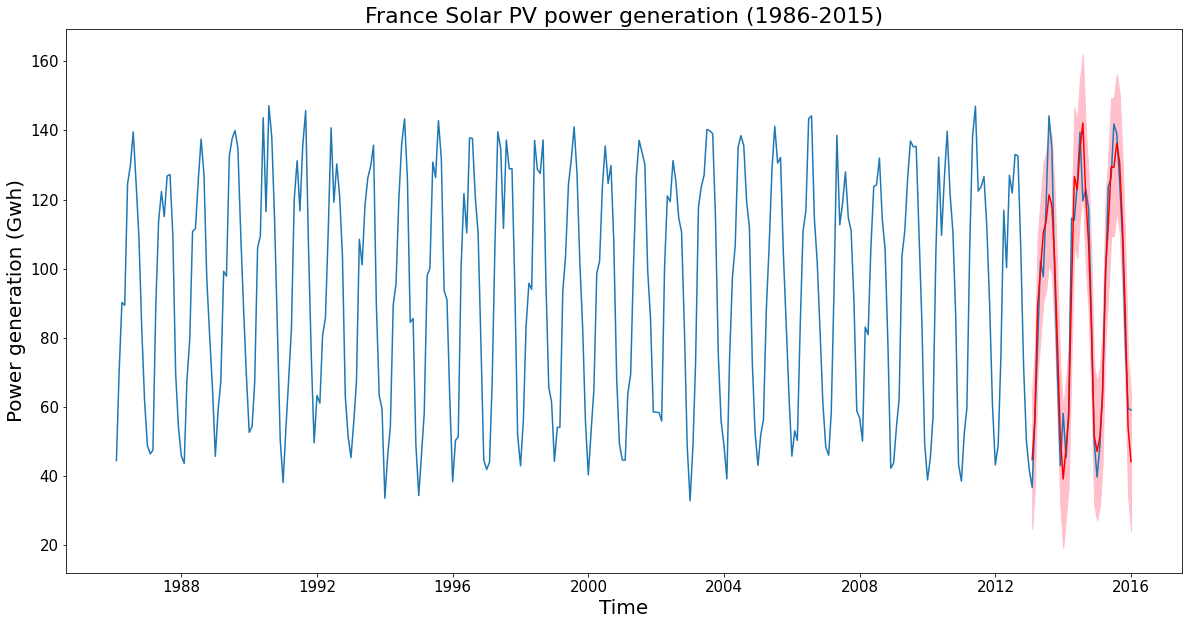

In [28]:
# plot the one-step-ahead prediction results
plt.figure(figsize=(20,10))
plt.plot(df_monthly.index, df_monthly.FR, label='observed')
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
plt.xlabel('Time', fontsize=20)
plt.ylabel("Power generation (Gwh)", fontsize = 20)
plt.title("France Solar PV power generation (1986-2015)", fontsize = 22)
plt.tick_params(axis='both', labelsize=15)